In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from matplotlib.pyplot import imshow
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import h5py
import json
from random import shuffle

In [153]:


class Data(Dataset):
    """
    gesture frame dataset.
    """

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the h5 sequences.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        data, sequencen,num= [], "", None
        if type(index) is list:
            sequence, num = index[0], index[1]
        else:
            sequence = index
        sequence = os.path.join(self.root_dir, sequence+ ".h5")
        for i in range(4):
            with h5py.File(sequence, 'r') as f:
                if num:
                    data.append(f['ch{}'.format(i)][num])
                    label = f['label'][num]
                else:
                    data.append(f['ch{}'.format(i)][()])
                    label = f['label'][()]
        data = np.stack((data[0], data[1], data[2], data[3]), axis=-1)
        if self.transform:
            data, label = self.transform((data, label))
        return data, label
        
    def get(self, gesture , session, instance):
        return self.__getitem__(str(gesture) + "_" + str(session) + "_"+ str(instance))
    def split(self, frames = False, already_defined = True, percentage = 0.5):
        """
        args : 
            frames: boolean, returns sets of (sequence, image number) if true, sets of sequences if false
            already_defined : returns the predefined train set if true, random if false
            percentage : percentage of the data in the train set
        return train and test sets
            
        """
        if not frames and already_defined:
            train, test = [], []
            with open("partitions/file_half.json") as f:#get the defined train set 
                train = json.load(f)["train"]
            for i in os.listdir(self.root_dir): # put the rest of the files in the test set
                if i[:-3] not in train:
                    test.append(i[:-3])
            return train, test
        elif not frames and not already_defined:
            data = list(map(lambda x : x[:-3] , os.listdir(self.root_dir)))#take all the sequences
            shuffle(data)#shuffle them 
            return data[: int(percentage * len(data))],data[int(percentage * len(data)): ]
        elif frames:
            if not os.path.exists('partitions/all_frames.json'):#if the list of all the image isn't created
                all_frames = []
                for i in os.listdir(self.root_dir):
                    with h5py.File(self.root_dir+ i, 'r') as f:
                        length = len(f['ch{}'.format(0)][()])
                        all_frames.extend([ (i[:-3],j) for j in  list(range(length))])
                with open('partitions/all_frames.json', 'w') as outfile:
                    json.dump({"data" : all_frames}, outfile)
            
            #open the set of frames, shuffle them and return the train test plit
            data = []
            with open('partitions/all_frames.json', 'r') as infile:
                data = json.load(infile)["data"]
            shuffle(data)
            return data[: int(percentage * len(data))],data[int(percentage * len(data)): ]
        
            

In [154]:
class Reshape(object):
    def __call__(self, sample):
        data, label = sample
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        if len(data.shape) == 3:# a whole sequence 
            data = data.reshape((data.shape[0], 32,32, 4))
        else: # a single frame
            data = data.reshape((32,32,4))
        return data, label
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple): Desired output size. If tuple, output is
            matched to output_size. 
    """

    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        newH, newW = self.output_size
        data, labels = sample[0], sample[1]
        if len(data.shape) == 4: # if sequence
            data = transform.resize(data, (data.shape[0], newH, newW, data.shape[3]))
        else:# if single frame
            data = transform.resize(data, (newH, newW, data.shape[3]))

        return data, label

In [155]:
class ToTensor(object):
    """reshapes ndarrays in sample to Tensors."""

    def __call__(self, sample):
        data, label= sample
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        if len(data.shape) == 4:# a whole sequence 
            data = data.transpose((0, 3, 1, 2))
        else: # a single frame
            data = data.transpose((2,0,1))
        return torch.from_numpy(data),torch.from_numpy(label)

In [165]:
sequences = Data("/home/chekirou/Documents/SOLI/SoliData/dsp/",transform = transforms.Compose([Reshape(), Rescale((224,224)), ToTensor()]) )

In [166]:
train, test = sequences.split(already_defined=False)

In [167]:
scale = Reshape()
r = Rescale((224,224))
t = ToTensor()
tr = transforms.Compose([scale, r, t])
for i in range(1):
    print(train[i])
    data, label = sequences[train[i]]

9_3_3


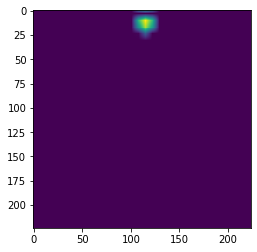

In [177]:
imshow(data[0][0,:,:])